In [1]:
%load_ext jupyter_cms

In [2]:
# <help>
print("I am also included in the help")

I am also included in the help


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import itertools
import matplotlib
import os
from Bio import SeqIO
from Bio import SeqUtils
import matplotlib.cm as cm
from ete3 import NCBITaxa
import re

In [4]:
def make_contig_df(contig_path, contig_name):
    """
    Make contig Dataframe from fasta file.
    """    
    f_handle = open(contig_path+'/'+contig_name, mode='r')
    contigs = SeqIO.parse(f_handle, 'fasta')
    contig_length = []
    contig_id =[]
    contig_GC = []
    assembly_id = []
    for x in contigs:
        contig_id.append(x.id)
        contig_length.append(len(x.seq))
        contig_GC.append(SeqUtils.GC(x.seq))
        assembly_id.append(p_and_a_ctg_file_name)
    s1 = pd.Series(contig_id, name='ID')
    s2 = pd.Series(contig_length, name='Length')
    s3 = pd.Series(contig_GC, name='%GC')
    s4 = pd.Series(assembly_id, name="Assembly")
    contig_df = pd.concat([s1, s2, s3, s4], axis=1)
    f_handle.close()
    return contig_df

In [5]:
#function to add another column for P and A_contig identification to dataframe
def P_and_A_identifier(df):
    """Method to add primary and alternative contig identifier rows to FC dataframes"""
    primary_list = []
    alternative_list = []
    return_df = df.iloc[:,:]
    for x in return_df['ID']:
        if "-" in list(x):
            primary_list.append(0)
            alternative_list.append(1)
        else:
            primary_list.append(1)
            alternative_list.append(0)
    return_df["P_contig"] = pd.Series(primary_list)
    return_df["A_contig"] = pd.Series(alternative_list)
    return_df = return_df.reset_index(drop=True)
    return return_df

In [6]:
#function that compares a seed with a result dataframe. It assesses if any initial IDs are missing from the result df
#and adds them with '0' in all columns to the result df
#ADD VALUE ERROR CHECK FOR EMPTY SEED_DF
def no_hit_df_extension(seed_df, result_df):
    """function that compares a seed with a result dataframe. 
    It assesses if any initial IDs are missing from the result df
    and adds them with '0' in all columns except the ID column.
    The first column in each dataframe needs to be labled 'ID'."""
    if len(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0]))) == 0:
        #test if there actually missing values
        return pd.DataFrame()
    else:
        no_hit_sr = pd.Series(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0])))
        #make empty dataframe for no_hits
        empty = np.array([[0]*(len(result_df.columns)-1) for x in range(len(no_hit_sr))])
        no_hit_df = pd.DataFrame(empty, columns =result_df.columns[1:])
        no_hit_df[result_df.columns.tolist()[0]] = no_hit_sr
        no_hit_df = no_hit_df[result_df.columns]
        return no_hit_df

In [7]:
def coverage_df_generator(file_path, file_name, seq_type):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    coverage_df = coverage_df.sort_values(by=[coverage_df.columns.tolist()[0]]).reset_index(drop=True)
    return coverage_df
#no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [8]:
def coverage_df_generator_all(file_path, file_name, seq_type, seed_df):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    This also adds the IDs for which no hits have been reported.
    It returns a sorted df on the first ID column.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    #get no hit df, append and sort
    coverage_all_df = coverage_df.append(no_hit_df_extension(seed_df, coverage_df))
    coverage_all_df = coverage_all_df.sort_values(by=[coverage_all_df.columns.tolist()[0]]).reset_index(drop=True)
    return coverage_all_df
    #no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [9]:
def add_cov_to_summary(sum_df, cov_df):
    """add coverage dataframe last "Average Coverage" column to blast summary df"""
    sum_sorted_df = sum_df.sort_values(by=[sum_df.columns.tolist()[0]]).reset_index(drop=True)
    cov_sorted_df = cov_df.sort_values(by=[cov_df.columns.tolist()[0]]).reset_index(drop=True)
    if set(sum_sorted_df.iloc[:,0] == cov_sorted_df.iloc[:,0]):
        sum_sorted_df[cov_sorted_df.columns.tolist()[-1]] = cov_sorted_df.iloc[:, -1]
        return sum_sorted_df
    else: #this should be made to raise an error
        print('Dataframes do not have the same ids')

In [10]:
def tc_blast_df(blast_xml_path, blast_xml_file_name, tc_list):
    """
    Returns a df of xml blast hits of target contigs.
    """
    from Bio.Blast import NCBIXML
    f = open(blast_xml_path+'/'+blast_xml_file_name, mode='r')
    blast_rec = NCBIXML.parse(f)
    tc_blast_df = pd.DataFrame()
    for record in blast_rec:
        if record.query.split(' ')[0] in tc_list: #the split may needs to be updated based on query blastn file headers.
                                                    #THINK long initial headers not _sh_ format
            NCBI_ID = []
            title_list = []
            query_contig = []
            sbj_start = []
            score_list =[]
            length=[]
            title = record.query.split(' ')[0]
            for aln in record.alignments:
                NCBI_ID.append('|'.join(aln.title.split('|')[0:4])+'|')
                title_list.append(aln.title.split('|')[4])
                query_contig.append(title)
                sbj_start_list = []
                query_score_list =[]
                length_list = []
                for hsp in aln.hsps:
                    sbj_start_list.append(hsp.query_start)
                    query_score_list.append(hsp.expect)
                    length_list.append(hsp.align_length)
                sbj_start.append(sbj_start_list)
                score_list.append(query_score_list)
                length.append(length_list)
            result_df = pd.concat([pd.Series(query_contig, name='ID'),pd.Series(NCBI_ID, name="ID-NCBI"), pd.Series(title_list, name='Blast Hit'), pd.Series(sbj_start, name='Contig Pos Aln'), pd.Series(length, name='Aln Length'), pd.Series(score_list, name='E-value')], axis =1)
            tc_blast_df = tc_blast_df.append(result_df)
    f.close()
    tc_blast_df = tc_blast_df.reset_index(drop=True)
    return tc_blast_df

In [11]:
def tc_blast_search_df(blast_xml_path, blast_xml_file_name, tc_list, search):
    """
    Returns a df of xml blast hits of target contigs were the query title matches the 'search' pattern.
    """
    from Bio.Blast import NCBIXML
    f = open(blast_xml_path+'/'+blast_xml_file_name, mode='r')
    blast_rec = NCBIXML.parse(f)
    tc_blast_df_2 = pd.DataFrame()
    for record in blast_rec:
        if record.query.split(' ')[0] in tc_list: #the split may needs to be updated based on query blastn file headers.                                            #THINK long initial headers not _sh_ format
            NCBI_ID = []
            title_list = []
            query_contig = []
            sbj_start = []
            score_list =[]
            length=[]
            title = record.query.split(' ')[0]
            #set the search term for your favorite blast hit
            for aln in record.alignments:
                #in case the title contains pattern match entered as search string in function
                if re.search(search, aln.title.split('|')[4]):
                    NCBI_ID.append('|'.join(aln.title.split('|')[0:4])+'|')
                    title_list.append(aln.title.split('|')[4])
                    query_contig.append(title)
                    sbj_start_list = []
                    query_score_list =[]
                    length_list = []
                    for hsp in aln.hsps:
                            sbj_start_list.append(hsp.query_start)
                            query_score_list.append(hsp.expect)
                            length_list.append(hsp.align_length)
                    sbj_start.append(sbj_start_list)
                    score_list.append(query_score_list)
                    length.append(length_list)
            result_df = pd.concat([pd.Series(query_contig, name='ID'),pd.Series(NCBI_ID, name="ID-NCBI"), pd.Series(title_list, name='Blast Hit'), pd.Series(sbj_start, name='Contig Pos Aln'), pd.Series(length, name='Aln Length'), pd.Series(score_list, name='E-value')], axis =1)
            tc_blast_df_2 = tc_blast_df_2.append(result_df)
            result_df = pd.DataFrame()
    f.close()
    tc_blast_df_2 = tc_blast_df_2.reset_index(drop=True)
    return tc_blast_df_2

In [12]:
def print_first_5_blast_hits(blast_xml_df):
    """
    Does what is says in conjungtion with tc_blast_df.
    """
    #set count and read in first row
    count = 0
    previous = blast_xml_df.loc[0,'ID']
    #iterarte over each row and print the long blast_xml description until you reach #5
    for index,row in blast_xml_df.iterrows():
        if row['ID'] == previous:
            count += 1
            #print(count)
        if count < 6: 
            print(blast_xml_df.loc[index, 'ID'], '\t', blast_xml_df.loc[index, 'Blast Hit'])
        if row['ID'] != previous:
            count = 0
        previous = row['ID']

In [13]:
def print_all_blast_hits(blast_xml_df):
    """
    Does what is says in conjungtion with tc_blast_df.
    """
    #set count and read in first row
    count = 0
    previous = blast_xml_df.loc[0,'ID']
    #iterarte over each row and print all blast hits
    for index,row in blast_xml_df.iterrows():
        print(blast_xml_df.loc[index, 'ID'], '\t', blast_xml_df.loc[index, 'Blast Hit'])
        print("E-value",'\t', blast_xml_df.loc[index, 'E-value'])
        print("Contig Pos Aln",'\t', blast_xml_df.loc[index,'Contig Pos Aln'])


In [14]:
#function to add another column for P and A_contig identification to dataframe
def P_and_H_identifier(df):
    """Method to add primary and alternative contig identifier rows to FC dataframes"""
    primary_list = []
    alternative_list = []
    return_df = df.iloc[:,:]
    for x in return_df['ID']:
        if "_" in list(x):
            primary_list.append(0)
            alternative_list.append(1)
        else:
            primary_list.append(1)
            alternative_list.append(0)
    return_df["P_contig"] = pd.Series(primary_list)
    return_df["A_contig"] = pd.Series(alternative_list)
    return_df = return_df.reset_index(drop=True)
    return return_df

In [15]:
#outdir for saving figures
outdir = "/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished"

In [16]:
#here pull in intial unpolished query file from Falcon p_and_a_ctg and generate a dataframe
p_and_a_ctg_path ='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/'
p_and_a_ctg_file_name = 'v91_pa_ctg.fa'
handle_1 = open(p_and_a_ctg_path+p_and_a_ctg_file_name)

In [17]:
#make dataframe of initial query file p_and_a_ctg_df
contigs = SeqIO.parse(handle_1, 'fasta')
contig_length = []
contig_id =[]
contig_GC = []
assembly_id = []
for x in contigs:
    contig_id.append(x.id)
    contig_length.append(len(x.seq))
    contig_GC.append(SeqUtils.GC(x.seq))
    assembly_id.append(p_and_a_ctg_file_name)
s1 = pd.Series(contig_id, name='ID')
s2 = pd.Series(contig_length, name='Length')
s3 = pd.Series(contig_GC, name='%GC')
s4 = pd.Series(assembly_id, name="Assembly")
p_and_a_ctg_df = pd.concat([s1, s2, s3, s4], axis=1)
handle_1.close()

In [18]:
p_and_a_ctg_df = P_and_A_identifier(p_and_a_ctg_df)

In [19]:
p_and_h_ctg_file_name = 'v91_all_ph_ctg.fa'
handle_2 = open(p_and_a_ctg_path+p_and_h_ctg_file_name)

In [20]:
#make dataframe of initial query file p_and_a_ctg_df
contigs = ''
contigs = SeqIO.parse(handle_2, 'fasta')
contig_length = []
contig_id =[]
contig_GC = []
assembly_id = []
for x in contigs:
    contig_id.append(x.id)
    contig_length.append(len(x.seq))
    contig_GC.append(SeqUtils.GC(x.seq))
    assembly_id.append(p_and_h_ctg_file_name)
s1 = pd.Series(contig_id, name='ID')
s2 = pd.Series(contig_length, name='Length')
s3 = pd.Series(contig_GC, name='%GC')
s4 = pd.Series(assembly_id, name="Assembly")
p_and_h_ctg_df = pd.concat([s1, s2, s3, s4], axis=1)
handle_2.close()

In [21]:
p_and_h_ctg_df = P_and_H_identifier(p_and_h_ctg_df)

In [22]:
cns_p_and_h_ctg_file_name = 'v91_cns_ph_ctg.fa'
handle_3 = open(p_and_a_ctg_path+cns_p_and_h_ctg_file_name)

In [23]:
#make dataframe of initial query file p_and_a_ctg_df
contigs = ''
contigs = SeqIO.parse(handle_3, 'fasta')
contig_length = []
contig_id =[]
contig_GC = []
assembly_id = []
for x in contigs:
    contig_id.append(x.id)
    contig_length.append(len(x.seq))
    contig_GC.append(SeqUtils.GC(x.seq))
    assembly_id.append(cns_p_and_h_ctg_file_name)
s1 = pd.Series(contig_id, name='ID')
s2 = pd.Series(contig_length, name='Length')
s3 = pd.Series(contig_GC, name='%GC')
s4 = pd.Series(assembly_id, name="Assembly")
cns_p_and_h_ctg_df = pd.concat([s1, s2, s3, s4], axis=1)
handle_3.close()

In [24]:
cns_p_and_h_ctg_df = P_and_H_identifier(cns_p_and_h_ctg_df)

In [26]:
p_and_h_ctg_df[p_and_h_ctg_df['Length']==0]

,ID,Length,%GC,Assembly,P_contig,A_contig
220,000230F,0,0.0,v91_all_ph_ctg.fa,1,0
234,000249F,0,0.0,v91_all_ph_ctg.fa,1,0


In [26]:
cns_ids = [x.split('|')[0] for x in cns_p_and_h_ctg_df['ID'].tolist()]

In [27]:
ph_ids = p_and_h_ctg_df['ID'].tolist()

In [28]:
absent_cns = list(set(ph_ids) -set(cns_ids))

In [29]:
absent_cns_df = pd.DataFrame()
for x in absent_cns:
    #print(p_and_h_ctg_df.query('ID=="%s"'%(x)))
    absent_cns_df=absent_cns_df.append(p_and_h_ctg_df.query('ID=="%s"'%(x)))


P_contig
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: Length, dtype: object

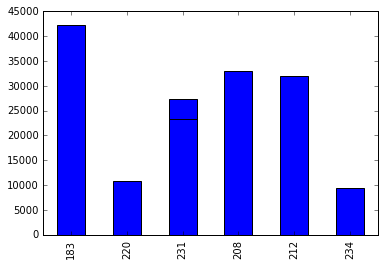

In [32]:
absent_cns_df.groupby('P_contig')['Length'].plot(kind='bar')

A_contig
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: Length, dtype: object

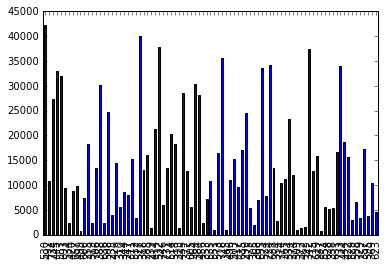

In [33]:
absent_cns_df.groupby('A_contig')['Length'].plot(kind='bar')

In [34]:
absent_cns_df.groupby('P_contig')['Length'].count()

P_contig
0    85
1     6
Name: Length, dtype: int64

In [35]:
p_and_h_ctg_df.groupby('P_contig')['Length'].sum()

P_contig
0    68673037
1    89868210
Name: Length, dtype: int64

In [61]:
cns_p_and_h_ctg_df.groupby('P_contig')['Length'].sum()

P_contig
0    67710241
1    89887834
Name: Length, dtype: int64

In [37]:
p_and_a_ctg_df.groupby('P_contig')['Length'].sum()

P_contig
0    37495020
1    92345074
Name: Length, dtype: int64

In [38]:
p_and_h_ctg_df[p_and_h_ctg_df['Length'] ==0]

,ID,Length,%GC,Assembly,P_contig,A_contig
220,000230F,0,0.0,v91_all_ph_ctg.fa,1,0
234,000249F,0,0.0,v91_all_ph_ctg.fa,1,0


In [41]:
p_and_h_zero_len_df = pd.DataFrame()
for y in p_and_h_ctg_df[p_and_h_ctg_df['Length'] ==0]['ID'].tolist():
    p_and_h_zero_len_df = p_and_h_zero_len_df.append(p_and_a_ctg_df.query('ID=="%s"'%(y)))
    

In [42]:
p_and_h_zero_len_df

,ID,Length,%GC,Assembly,P_contig,A_contig
230,000230F,26987,42.687220,v91_pa_ctg.fa,1,0
249,000249F,20504,42.913578,v91_pa_ctg.fa,1,0


In [177]:
absent_cns_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig
435,000018F_003,28466,43.163774,v91_all_ph_ctg.fa,0,1
384,000012F_009,28086,42.879014,v91_all_ph_ctg.fa,0,1
338,000007F_003,5320,39.436090,v91_all_ph_ctg.fa,0,1
337,000007F_002,693,47.763348,v91_all_ph_ctg.fa,0,1
377,000011F_009,12779,47.953674,v91_all_ph_ctg.fa,0,1


In [89]:
#add another column to the data frame that IDs the primary associated contig
primary_ID = []
for x in cns_p_and_h_ctg_df['ID']:
    if "_" in list(x):
        primary_ID.append(x[0:7])
    else:
        primary_ID.append(x[0:7])
cns_p_and_h_ctg_df["P_ID"] = pd.Series(primary_ID)

In [119]:
len(set(cns_p_and_h_ctg_df['P_ID']))

231

In [110]:
cns_p_and_h_ctg_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,P_ID
0,000241F|quiver,24591,32.853483,v91_cns_ph_ctg.fa,1,0,000241F
1,000245F|quiver,23773,31.518950,v91_cns_ph_ctg.fa,1,0,000245F
2,000247F|quiver,22045,31.317759,v91_cns_ph_ctg.fa,1,0,000247F
3,000248F|quiver,21899,45.152747,v91_cns_ph_ctg.fa,1,0,000248F
4,000190F|quiver,40395,32.573338,v91_cns_ph_ctg.fa,1,0,000190F


In [111]:
#get all contigs with haplotigs
p_w_h_list = list(set(cns_p_and_h_ctg_df[(cns_p_and_h_ctg_df['P_contig'] == 0)]['P_ID']))

In [112]:
len(p_w_h_list)

104

In [115]:
#get all contigs without haplotigs
p_wo_h_list =[]
p_wo_h_list =  list(set(cns_p_and_h_ctg_df[cns_p_and_h_ctg_df['P_contig'] ==1]['P_ID']) - set(p_w_h_list))

In [116]:
len(p_wo_h_list)

127

In [125]:
total_seq_recs = 0
p_w_h_contigs =[]
p_wo_h_contigs = []
pwh_count =0
pwoh_count =0
for seq_record in SeqIO.parse(p_and_a_ctg_path+'/'+cns_p_and_h_ctg_file_name, "fasta"):
    if seq_record.id.split('|')[0] in p_w_h_list:
        p_w_h_contigs.append(seq_record)
        pwh_count += 1
    if seq_record.id.split('|')[0] in p_wo_h_list:
        p_wo_h_contigs.append(seq_record)
        pwoh_count += 1
    total_seq_recs += 1

In [ ]:
#there are two h_ctgs for which the associated p_contigs was ommitted from the analysis in Falcon_unzip

In [122]:
len(p_wo_h_list)

127

In [126]:
SeqIO.write(p_wo_h_contigs,cns_p_and_h_ctg_file_name[0:(len(cns_p_and_h_ctg_file_name)-3)]+'_pwoh_ctg.fa' , 'fasta')

127

In [127]:
SeqIO.write(p_w_h_contigs,cns_p_and_h_ctg_file_name[0:(len(cns_p_and_h_ctg_file_name)-3)]+'_pwh_ctg.fa' , 'fasta')

102

In [128]:
nucmer_dir ='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/v91_cns/nucmer_pwoh_on_pwh/'

In [147]:
for seq in SeqIO.parse(cns_p_and_h_ctg_file_name[0:(len(cns_p_and_h_ctg_file_name)-3)]+'_pwoh_ctg.fa', 'fasta'):
    SeqIO.write(seq, nucmer_dir+seq.id.split('|')[0]+"_quiver.fa", 'fasta')

In [132]:
SeqIO.write(p_w_h_contigs,nucmer_dir+cns_p_and_h_ctg_file_name[0:(len(cns_p_and_h_ctg_file_name)-3)]+'_pwh_ctg.fa' , 'fasta')
SeqIO.write(p_wo_h_contigs,nucmer_dir+cns_p_and_h_ctg_file_name[0:(len(cns_p_and_h_ctg_file_name)-3)]+'_pwoh_ctg.fa' , 'fasta')

127

In [168]:
#initiate nucmer bash script writting
bash_script="v91_cns_ph_pwoh_on_pwh_nucmer.sh"

In [173]:
os.chdir(nucmer_dir)
outf = open(bash_script, 'w')
outf.write('#!/bin/bash\n')

12

In [174]:
p_w_h_contigs_fn = cns_p_and_h_ctg_file_name[0:(len(cns_p_and_h_ctg_file_name)-3)]+'_pwh_ctg.fa'

In [175]:
for seq in SeqIO.parse(cns_p_and_h_ctg_file_name[0:(len(cns_p_and_h_ctg_file_name)-3)]+'_pwoh_ctg.fa', 'fasta'):
        _id=seq.id.split('|')[0]+"_quiver"
        outf.write('nucmer '+p_w_h_contigs_fn+' '+_id+".fa > "+'out.delta\n')
        outf.write('delta-filter -g '+'out.delta'+" > "+_id+"_gfiltered.delta\n")
        outf.write('show-coords -T '+_id+"_gfiltered.delta > "+_id+".gcoords\n")
        outf.write('delta-filter -r '+'out.delta'+" > "+_id+"_rfiltered.delta\n")
        outf.write('show-coords -T '+_id+"_gfiltered.delta > "+_id+".rcoords\n")
        outf.write('mummerplot -p '+_id+'_rfiltered --postscript '+_id+"_rfiltered.delta\n")
        outf.write('mummerplot -c -p  '+_id+'_rfiltered_cov --postscript '+_id+"_rfiltered.delta\n")
        outf.write('mummerplot -p '+_id+'_gfiltered --postscript '+_id+"_gfiltered.delta\n")
        outf.write('mummerplot -c -p  '+_id+'_gfiltered_cov --postscript '+_id+"_gfiltered.delta\n")
outf.close()

In [147]:
#get all haplcontigs that are not mitochondrial
h_list = list(set(below_200_cov[(below_200_cov['A_contig'] == 1)]['ID']))

In [149]:
len(h_list)

267

In [162]:
total_seq_recs = 0
h_contigs =[]
h_contigs_plus_200=[]
h_count =0
for seq_record in SeqIO.parse(p_and_a_ctg_path+'/'+p_and_a_ctg_file_name, "fasta"):
    if seq_record.id in h_list:
        h_contigs.append(seq_record)
        h_count += 1
    if '_' in list(seq_record.id) and seq_record.id not in h_list:
        h_contigs_plus_200.append(seq_record)
    total_seq_recs += 1